In [2]:
# Import `numpy` under the alias `np`
import numpy as np 

# Import `pandas` under the alias `pd`
import pandas as pd 
import pmdarima as pm

import itertools #to iterate through the loops

import statsmodels.api as sm

import matplotlib.pyplot as plt 
import matplotlib as mpl
%matplotlib inline 

import plotly.express as px
import plotly.offline as py

import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from pandas import Series

from datetime import datetime
from matplotlib import pyplot


from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX

#FBProphet related imports
from fbprophet import Prophet
from fbprophet.plot import plot_plotly
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics

#Importing the Auto-Arima function 
from pmdarima import auto_arima

from sklearn.metrics import mean_absolute_error

 # to split the data into train and test parts
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score 


def p_mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


# Reading the data from a file

In [3]:
df = pd.read_excel('Sales_Forecast_Data-Original.xlsx')

In [4]:
df.head() # returns top n (5 by default) rows of a data frame

FIN_YEAR MONTH    STATE            FG DISTRICT  COMPANY    VALUE
0  2014-2015   Nov  Haryana  Insecticides   Rohtak  monous    675.00
1  2014-2015   Nov  Haryana  Insecticides   Rewari  monous     73.71
2  2014-2015   Nov  Haryana  Insecticides  Gurgaon  monous    405.00
3  2014-2015   Nov  Haryana  Insecticides    Mewat  monous   1188.00
4  2014-2015   Nov  Haryana  Insecticides   Palwal  monous   5188.59

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230152 entries, 0 to 230151
Data columns (total 7 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   FIN_YEAR  230152 non-null  object 
 1   MONTH     230152 non-null  object 
 2   STATE     230152 non-null  object 
 3   FG        230152 non-null  object 
 4   DISTRICT  230152 non-null  object 
 5   COMPANY   230152 non-null  object 
 6   VALUE     230152 non-null  float64
dtypes: float64(1), object(6)
memory usage: 12.3+ MB


# Data Preparation for modelling : using ABC Manufacturing data only

In [6]:
#Constants used within this file
train_start_date = '2014-01-01'
train_end_date = '2016-12-01'
test_start_date = '2017-01-01'
test_end_date = '2017-12-01'
consider_rolling_window = False
consider_mean_values = True
predict_periods=12
missing_record_index = 37

In [7]:
if consider_rolling_window == False:
    rolling_period = 3
else:
    #do not change this value
    rolling_period = 1     

In [8]:
#Creating a dataframe of ABC manufacturing
ABC_df = df.loc[df['COMPANY'] == 'ABC Manufacturing']

In [9]:
#converting year range to year  . for example  "2014-2015"  will be converted to 2014 
ABC_df['FIN_YEAR'] = ABC_df.FIN_YEAR.str.slice(0,4)

#converting month to datetime for checking stationarity  
ABC_df['MONTH'] = pd.to_datetime(ABC_df['FIN_YEAR'].astype(str)+ "-"+ ABC_df['MONTH'].astype(str) + "-1")

In [10]:
ABC_df.isnull().sum() #Checking the null values in the ABC manufacturing company

FIN_YEAR    0
MONTH       0
STATE       0
FG          0
DISTRICT    0
COMPANY     0
VALUE       0
dtype: int64

In [11]:
ABC_df.isna().sum() 

FIN_YEAR    0
MONTH       0
STATE       0
FG          0
DISTRICT    0
COMPANY     0
VALUE       0
dtype: int64

In [12]:
#Considering only Uttar Pradesh data for ABC manufacturing company only
ABC_df = ABC_df.loc[ (ABC_df['STATE'] == 'Uttar Pradesh')]
ABC_df

FIN_YEAR      MONTH          STATE            FG      DISTRICT  \
2263       2014 2014-04-01  Uttar Pradesh  Insecticides    Rae Bareli   
2264       2014 2014-04-01  Uttar Pradesh  Insecticides        Etawah   
2265       2014 2014-04-01  Uttar Pradesh  Insecticides  Kanpur Dehat   
2266       2014 2014-04-01  Uttar Pradesh  Insecticides  Kanpur Nagar   
2267       2014 2014-04-01  Uttar Pradesh  Insecticides        Jalaun   
...         ...        ...            ...           ...           ...   
229858     2016 2016-01-01  Uttar Pradesh  Bactericides      Mirzapur   
230144     2016 2016-12-01  Uttar Pradesh  Bactericides      Faizabad   
230145     2016 2016-12-01  Uttar Pradesh  Bactericides         Basti   
230146     2016 2016-12-01  Uttar Pradesh  Bactericides        Ballia   
230147     2016 2016-12-01  Uttar Pradesh  Bactericides          Etah   

                  COMPANY    VALUE  
2263    ABC Manufacturing  978.075  
2264    ABC Manufacturing   39.015  
2265    ABC Manufacturing    0.000  
2266    ABC Manufacturing  196.965  
2267    ABC Manufacturing  515.700  
...                   ...      ...  
229858  ABC Manufacturing    0.000  
230144  ABC Manufacturing    0.000  
230145  ABC Manufacturing    0.000  
230146  ABC Manufacturing    0.000  
230147  ABC Manufacturing    0.000  

[13024 rows x 7 columns]

In [13]:
ABC_df.describe()

VALUE
count  13024.000000
mean    2687.703816
std     5198.805612
min        0.000000
25%        0.000000
50%      195.547500
75%     3304.800000
max    69828.750000

In [14]:
ABC_df_Pesticides = ABC_df.copy(deep=True)
ABC_df_Pesticides.drop(['FIN_YEAR', 'STATE', 'FG', 'DISTRICT', 'COMPANY'],axis=1,inplace = True)

In [15]:
# Upon inspection it is found that for a period of Feb and March in 2017, there was no data. 
# We need to treat this data else seasonal_decompose() will throw error

In [16]:
# SUM 

if consider_mean_values == False:
    ABC_df_Pesticides = ABC_df_Pesticides.groupby('MONTH')['VALUE'].sum().reset_index()
    
    df1 = ABC_df_Pesticides[: missing_record_index]
    df2 = ABC_df_Pesticides[missing_record_index:]

    new_row = {'MONTH': datetime.strptime('2017-02-01', '%Y-%m-%d').date(), 'VALUE':595022.985}
    df1.loc[missing_record_index] = new_row

    new_row = {'MONTH': datetime.strptime('2017-03-01', '%Y-%m-%d').date(), 'VALUE':1698554.106 }
    df1.loc[missing_record_index + 1] = new_row
                        
    ABC_df_Pesticides = pd.concat([df1, df2])                                 

In [17]:
# MEAN 

if consider_mean_values == True:
    ABC_df_Pesticides = ABC_df_Pesticides.groupby('MONTH')['VALUE'].mean().reset_index()
    
    df1 = ABC_df_Pesticides[: missing_record_index]
    df2 = ABC_df_Pesticides[missing_record_index:]

    new_row = {'MONTH': datetime.strptime('2017-02-01', '%Y-%m-%d').date(), 'VALUE':2077 }
    df1.loc[missing_record_index] = new_row

    new_row = {'MONTH': datetime.strptime('2017-03-01', '%Y-%m-%d').date(), 'VALUE':5897 }
    df1.loc[missing_record_index + 1] = new_row
                        
    ABC_df_Pesticides = pd.concat([df1, df2])
    

In [18]:
ABC_df_Pesticides

MONTH        VALUE
0   2014-01-01 00:00:00  2838.262500
1   2014-02-01 00:00:00  2332.428275
2   2014-03-01 00:00:00  5700.845625
3   2014-04-01 00:00:00   660.625000
4   2014-05-01 00:00:00  1593.079476
5   2014-06-01 00:00:00  1978.078821
6   2014-07-01 00:00:00  2538.479155
7   2014-08-01 00:00:00  3830.933906
8   2014-09-01 00:00:00  2614.252500
9   2014-10-01 00:00:00  2458.408125
10  2014-11-01 00:00:00  4970.405625
11  2014-12-01 00:00:00  3644.532187
12  2015-01-01 00:00:00  2742.117656
13  2015-02-01 00:00:00  1879.643438
14  2015-03-01 00:00:00  7080.092344
15  2015-04-01 00:00:00  1851.711618
16  2015-05-01 00:00:00  2693.603352
17  2015-06-01 00:00:00  2537.732935
18  2015-07-01 00:00:00  3132.405925
19  2015-08-01 00:00:00  2864.210625
20  2015-09-01 00:00:00  2864.695781
21  2015-10-01 00:00:00  2294.491875
22  2015-11-01 00:00:00  3249.614063
23  2015-12-01 00:00:00  2935.531406
24  2016-01-01 00:00:00  2874.163125
25  2016-02-01 00:00:00  2018.479219
26  2016-03-01 00:00:00  4912.333969
27  2016-04-01 00:00:00   963.712742
28  2016-05-01 00:00:00  2167.770170
29  2016-06-01 00:00:00  2011.367045
30  2016-07-01 00:00:00  1969.149375
31  2016-08-01 00:00:00  2561.995312
32  2016-09-01 00:00:00  2075.745000
33  2016-10-01 00:00:00  1407.628594
34  2016-11-01 00:00:00  3151.923750
35  2016-12-01 00:00:00  2886.590250
36  2017-01-01 00:00:00  2515.909932
37           2017-02-01  2077.000000
38           2017-03-01  5897.000000
37  2017-04-01 00:00:00   519.129844
38  2017-05-01 00:00:00  1844.698821
39  2017-06-01 00:00:00  1610.297100
40  2017-07-01 00:00:00  1923.215929
41  2017-08-01 00:00:00  2018.469375
42  2017-09-01 00:00:00  1799.250300
43  2017-10-01 00:00:00  2400.986250
44  2017-11-01 00:00:00  4115.546550
45  2017-12-01 00:00:00  3303.355050

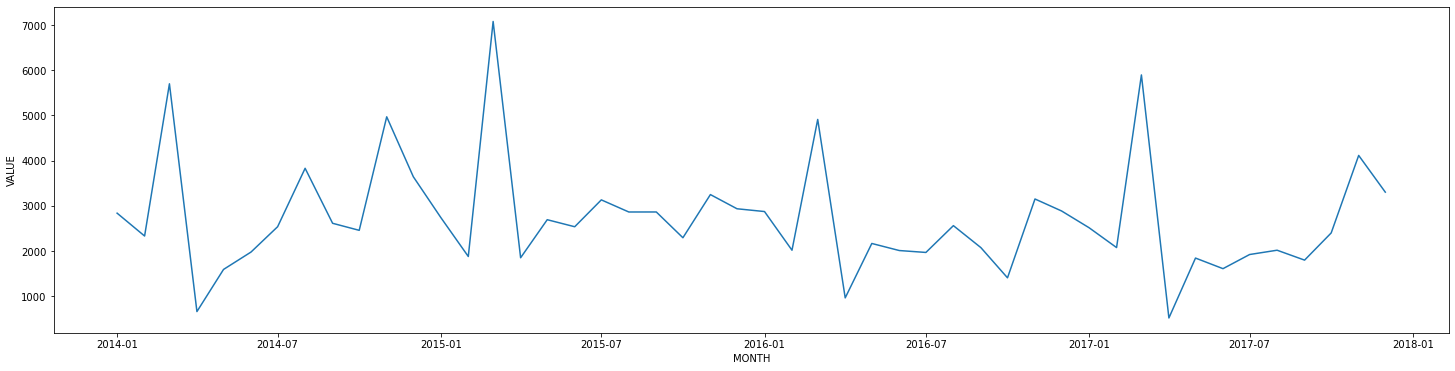

In [19]:
#Plot the data 
plt.figure(figsize=(25,6))
sns.lineplot(x="MONTH", y="VALUE", data=ABC_df_Pesticides,  ci= None)

In [20]:
if consider_rolling_window == True:
    xyzseries = ABC_df_Pesticides['VALUE'].rolling(window = rolling_period)
    XYZmean = xyzseries.mean()
    plt.figure(figsize=(25,6))
    sns.lineplot( data=XYZmean,  ci= None)
    

[Text(0, 0, 'VALUE')]

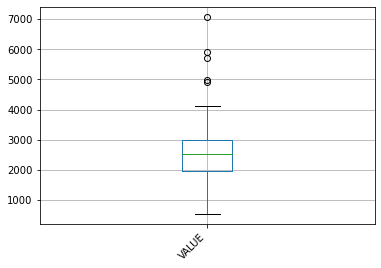

In [21]:
boxplot = ABC_df_Pesticides.boxplot(column=['VALUE'])
boxplot.set_xticklabels(boxplot.get_xticklabels(), rotation=45, horizontalalignment='right')

In [22]:
ABC_df_Pesticides.describe()

VALUE
count    48.000000
mean   2714.831248
std    1284.183176
min     519.129844
25%    1975.846460
50%    2526.821433
75%    2984.750036
max    7080.092344

In [23]:
print(ABC_df_Pesticides["VALUE"].quantile(0.95))

5445.191625


In [24]:
#ABC_df_Pesticides["VALUE"]=np.where(ABC_df_Pesticides["VALUE"]>66082.66875,66082.66875,ABC_df_Pesticides["VALUE"])

In [25]:
if consider_rolling_window == True:
    ABC_df_Pesticides['VALUE'] = XYZmean
    ABC_df_Pesticides = ABC_df_Pesticides[rolling_period - 1:]


# Check for Stationarity and Seasonality

In [26]:
# for a time series to be Sationary
# 1. Mean has to be constant 
# 2. variance has to be constant 
# 3. No seasonality

# If a timeseries has seasonality, then it is not stationary. i.e ARMA models cannot be run.

In [27]:
# Augmented Dickey FULLER test to check Stationarity

def ADF_test(timeseries):
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))

In [28]:
ADF_test(ABC_df_Pesticides['VALUE'])

Test statistic = -8.342
P-value = 0.000
Critical values :
	1%: -3.5778480370438146 - The data is  stationary with 99% confidence
	5%: -2.925338105429433 - The data is  stationary with 95% confidence
	10%: -2.6007735310095064 - The data is  stationary with 90% confidence


In [29]:
# from the above result, as p-value < 0.05... we can conclude that the timeseries data is Stationary

In [30]:
# Additional check using KPSS method   [ Kwiatkowski–Phillips–Schmidt–Shin (KPSS)]
# Ref: https://www.statisticshowto.com/kpss-test/

stats, p, lags, critical_values = kpss(ABC_df_Pesticides['VALUE'],'c')
stats, p, lags, critical_values

print(f'Test Statistics: {stats}')
print(f'p value: {p}')
print(f'critical_values: {critical_values}')



Test Statistics: 0.2560181854156337
p value: 0.1
critical_values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


In [31]:
# as 0.1  is greater than 0.05, we can conclude that the timeseries data is Stationary

In [32]:
ABC_df_Pesticides.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48 entries, 0 to 45
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   MONTH   48 non-null     object 
 1   VALUE   48 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.1+ KB


In [33]:
# Reset index after converting 'Month' to Datetime
ABC_df_Pesticides['MONTH'] = pd.to_datetime(ABC_df_Pesticides['MONTH'])
ABC_df_Pesticides.set_index('MONTH', inplace=True)

In [34]:
ABC_df_Pesticides

VALUE
MONTH                  
2014-01-01  2838.262500
2014-02-01  2332.428275
2014-03-01  5700.845625
2014-04-01   660.625000
2014-05-01  1593.079476
2014-06-01  1978.078821
2014-07-01  2538.479155
2014-08-01  3830.933906
2014-09-01  2614.252500
2014-10-01  2458.408125
2014-11-01  4970.405625
2014-12-01  3644.532187
2015-01-01  2742.117656
2015-02-01  1879.643438
2015-03-01  7080.092344
2015-04-01  1851.711618
2015-05-01  2693.603352
2015-06-01  2537.732935
2015-07-01  3132.405925
2015-08-01  2864.210625
2015-09-01  2864.695781
2015-10-01  2294.491875
2015-11-01  3249.614063
2015-12-01  2935.531406
2016-01-01  2874.163125
2016-02-01  2018.479219
2016-03-01  4912.333969
2016-04-01   963.712742
2016-05-01  2167.770170
2016-06-01  2011.367045
2016-07-01  1969.149375
2016-08-01  2561.995312
2016-09-01  2075.745000
2016-10-01  1407.628594
2016-11-01  3151.923750
2016-12-01  2886.590250
2017-01-01  2515.909932
2017-02-01  2077.000000
2017-03-01  5897.000000
2017-04-01   519.129844
2017-05-01  1844.698821
2017-06-01  1610.297100
2017-07-01  1923.215929
2017-08-01  2018.469375
2017-09-01  1799.250300
2017-10-01  2400.986250
2017-11-01  4115.546550
2017-12-01  3303.355050

<Figure size 2160x2520 with 0 Axes>

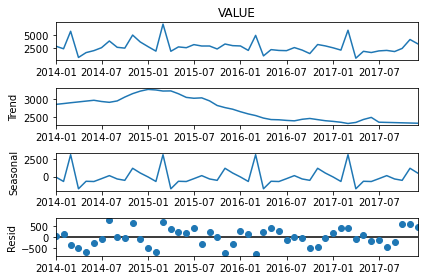

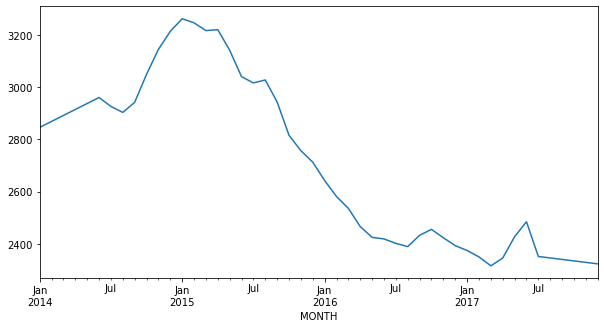

In [35]:
res = sm.tsa.seasonal_decompose(ABC_df_Pesticides['VALUE'],model = 'additive',extrapolate_trend='freq')

plt.figure(figsize=(30,35))
resplot = res.plot(observed=True)

plt.figure(figsize=(10, 5))
res.trend.plot()

# FBProphet Model

In [36]:
ABC_df_Pesticides_FBP =  ABC_df_Pesticides.copy(deep=True)

In [37]:
ABC_df_Pesticides_FBP = ABC_df_Pesticides_FBP.reset_index()[['MONTH','VALUE']].rename({'MONTH':'ds','VALUE':'y'}, axis='columns')

In [38]:
train = ABC_df_Pesticides_FBP[ABC_df_Pesticides_FBP['ds'] <= pd.to_datetime(train_end_date)]
train

ds            y
0  2014-01-01  2838.262500
1  2014-02-01  2332.428275
2  2014-03-01  5700.845625
3  2014-04-01   660.625000
4  2014-05-01  1593.079476
5  2014-06-01  1978.078821
6  2014-07-01  2538.479155
7  2014-08-01  3830.933906
8  2014-09-01  2614.252500
9  2014-10-01  2458.408125
10 2014-11-01  4970.405625
11 2014-12-01  3644.532187
12 2015-01-01  2742.117656
13 2015-02-01  1879.643438
14 2015-03-01  7080.092344
15 2015-04-01  1851.711618
16 2015-05-01  2693.603352
17 2015-06-01  2537.732935
18 2015-07-01  3132.405925
19 2015-08-01  2864.210625
20 2015-09-01  2864.695781
21 2015-10-01  2294.491875
22 2015-11-01  3249.614063
23 2015-12-01  2935.531406
24 2016-01-01  2874.163125
25 2016-02-01  2018.479219
26 2016-03-01  4912.333969
27 2016-04-01   963.712742
28 2016-05-01  2167.770170
29 2016-06-01  2011.367045
30 2016-07-01  1969.149375
31 2016-08-01  2561.995312
32 2016-09-01  2075.745000
33 2016-10-01  1407.628594
34 2016-11-01  3151.923750
35 2016-12-01  2886.590250

In [39]:
test = ABC_df_Pesticides_FBP[ABC_df_Pesticides_FBP['ds'] > pd.to_datetime(train_end_date)]
test

ds            y
36 2017-01-01  2515.909932
37 2017-02-01  2077.000000
38 2017-03-01  5897.000000
39 2017-04-01   519.129844
40 2017-05-01  1844.698821
41 2017-06-01  1610.297100
42 2017-07-01  1923.215929
43 2017-08-01  2018.469375
44 2017-09-01  1799.250300
45 2017-10-01  2400.986250
46 2017-11-01  4115.546550
47 2017-12-01  3303.355050

In [40]:
test.rename({'ds' : 'MONTH','y' : 'VALUE'},axis=1,inplace=True)
test.set_index('MONTH', inplace=True)

In [41]:
test

VALUE
MONTH                  
2017-01-01  2515.909932
2017-02-01  2077.000000
2017-03-01  5897.000000
2017-04-01   519.129844
2017-05-01  1844.698821
2017-06-01  1610.297100
2017-07-01  1923.215929
2017-08-01  2018.469375
2017-09-01  1799.250300
2017-10-01  2400.986250
2017-11-01  4115.546550
2017-12-01  3303.355050

In [42]:
#run the model with confidence interval of 95%
m = Prophet(interval_width=0.95, yearly_seasonality=True)

In [43]:
m.fit(train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [44]:
m.params

{'k': array([[0.10891914]]),
 'm': array([[0.36879338]]),
 'delta': array([[ 5.68861133e-10, -4.93203965e-10, -7.61864314e-11,
         -3.72018584e-10, -8.76731098e-10,  4.32212951e-10,
         -1.39750829e-08, -1.19543585e-05, -1.27353121e-04,
         -2.07204670e-04, -5.29096982e-04, -5.63113135e-04,
         -7.32390678e-04, -3.28643139e-01, -8.81108841e-04,
         -1.26303781e-04, -1.18839263e-04, -1.39798133e-04,
         -9.97314639e-07,  1.11899406e-10, -2.29901200e-10,
         -4.79663514e-11, -5.98199142e-10,  3.04033157e-10,
         -3.20601077e-10]]),
 'sigma_obs': array([[0.04555928]]),
 'beta': array([[-5.01036741e-02,  2.03246530e-02,  1.44194403e-01,
          2.96018022e-01,  2.35986413e-01, -1.35812965e-03,
         -1.58982652e-01, -3.26588817e-01, -1.50468549e-01,
         -1.80149259e-01, -3.76233785e-01,  2.97514130e-02,
         -1.20909038e-01,  2.25203253e-01, -1.70677015e-01,
          2.22580431e-01,  2.85963880e-01, -2.55942649e-04,
          2.1150834

In [45]:
future = m.make_future_dataframe(periods=predict_periods,freq='MS')

In [46]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

ds         yhat   yhat_lower   yhat_upper
0  2014-01-01  2749.081045  2097.709687  3345.507754
1  2014-02-01  2258.400303  1606.502631  2868.303179
2  2014-03-01  6026.056731  5437.317011  6676.142554
3  2014-04-01  1154.269529   566.060529  1746.143728
4  2014-05-01  2145.084534  1494.790238  2785.931224
5  2014-06-01  2227.246349  1639.422857  2834.441910
6  2014-07-01  2724.505379  2073.730679  3322.572926
7  2014-08-01  3252.818864  2579.670256  3904.842849
8  2014-09-01  2765.065085  2087.364070  3411.697132
9  2014-10-01  2374.156726  1731.265802  3000.369173
10 2014-11-01  4101.667901  3500.695162  4778.727034
11 2014-12-01  3471.947951  2909.964176  4090.084564
12 2015-01-01  3020.640589  2359.317593  3704.543343
13 2015-02-01  2300.410523  1655.540098  2914.802510
14 2015-03-01  6722.835479  6112.431727  7413.003829
15 2015-04-01  1364.869857   737.803150  1983.360929
16 2015-05-01  2168.640920  1472.388513  2818.053111
17 2015-06-01  2237.201505  1602.004273  2855.245899
18 2015-07-01  2911.549270  2242.789133  3537.960826
19 2015-08-01  3196.142296  2561.568484  3794.514152
20 2015-09-01  2747.483710  2169.418871  3410.774433
21 2015-10-01  2366.684654  1802.973820  3046.187347
22 2015-11-01  3849.505630  3214.845069  4482.537421
23 2015-12-01  3051.661876  2433.972245  3668.764146
24 2016-01-01  2685.968585  2043.062719  3295.612570
25 2016-02-01  1673.820247  1028.191840  2298.439117
26 2016-03-01  4944.743598  4320.689286  5587.203337
27 2016-04-01   957.607561   335.217966  1628.231609
28 2016-05-01  2140.243080  1520.863078  2783.263910
29 2016-06-01  2062.437050  1439.868498  2693.047801
30 2016-07-01  2002.825640  1440.980666  2675.504915
31 2016-08-01  2807.647550  2169.532753  3401.327268
32 2016-09-01  2041.345152  1386.120034  2661.828869
33 2016-10-01  1419.386453   818.601535  2035.971078
34 2016-11-01  3421.397371  2816.316625  4048.037775
35 2016-12-01  2943.909000  2269.690528  3566.060892
36 2017-01-01  2120.772012  1478.821072  2784.762180
37 2017-02-01  1796.687450  1153.071919  2417.690394
38 2017-03-01  4839.051076  4202.252163  5483.111513
39 2017-04-01   378.586649  -295.204540   982.898623
40 2017-05-01  1429.628674   827.777463  2072.113031
41 2017-06-01  1394.566314   759.307330  2040.539505
42 2017-07-01  1580.868313   934.039119  2241.143425
43 2017-08-01  2214.197434  1569.993174  2852.297392
44 2017-09-01  1552.092705   901.810711  2162.309275
45 2017-10-01  1014.541397   371.973040  1620.052826
46 2017-11-01  2846.750945  2208.633922  3463.579083
47 2017-12-01  2257.669149  1621.449672  2886.266871

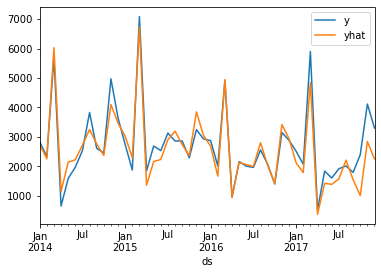

In [47]:
pd.concat([ABC_df_Pesticides_FBP.set_index('ds')['y'],forecast.set_index('ds')['yhat']],axis=1).plot()

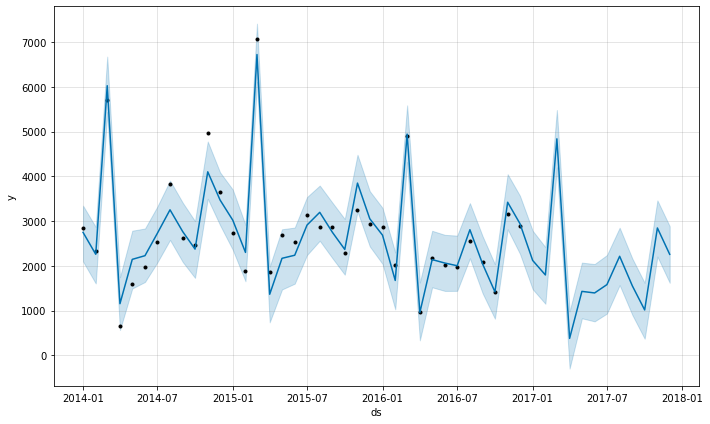

In [48]:
fig1 = m.plot(forecast)

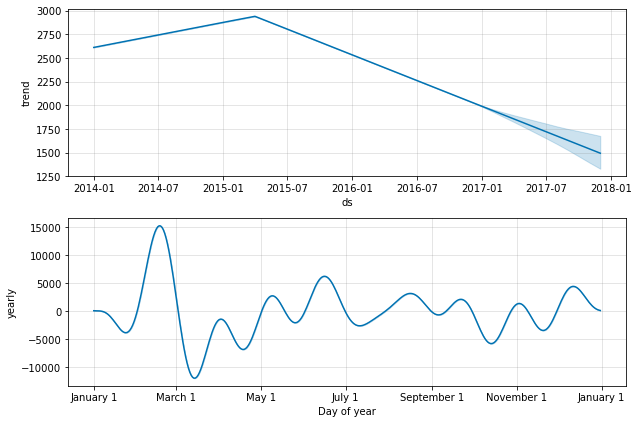

In [49]:
fig2 = m.plot_components(forecast)

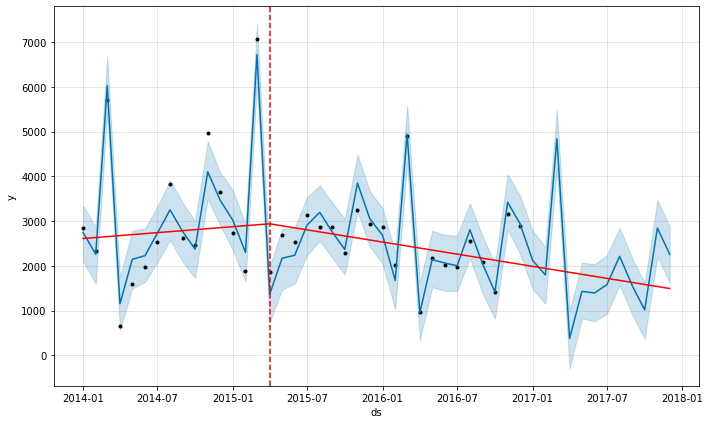

In [50]:
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [51]:
fig = plot_plotly(m, forecast)  # This returns a plotly Figure
py.iplot(fig)

In [52]:
#check for cross_validation
cv_results = cross_validation( model = m, initial = '731 days', horizon = '120 days')
cv_results

INFO:fbprophet:Making 4 forecasts with cutoffs between 2016-02-05 00:00:00 and 2016-08-03 00:00:00


INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:n_changepoints greater than number of observations. Using 21.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.
INFO:fbprophet:n_changepoints greater than number of observations. Using 24.


ds         yhat   yhat_lower   yhat_upper            y     cutoff
0  2016-03-01  5287.318824  4571.104142  6017.573231  4912.333969 2016-02-05
1  2016-04-01  1238.196761   558.002473  1987.068184   963.712742 2016-02-05
2  2016-05-01  2335.841502  1637.266985  3019.020303  2167.770170 2016-02-05
3  2016-06-01  3153.307210  2464.924577  3798.774583  2011.367045 2016-02-05
4  2016-05-01  2411.832135  1848.890590  3029.588562  2167.770170 2016-04-05
5  2016-06-01  3074.842323  2464.632702  3716.924793  2011.367045 2016-04-05
6  2016-07-01  2366.122339  1719.033796  2979.890381  1969.149375 2016-04-05
7  2016-08-01  5494.620901  4854.322771  6134.584480  2561.995312 2016-04-05
8  2016-07-01  2463.865702  1901.997216  3063.806448  1969.149375 2016-06-04
9  2016-08-01  5473.871347  4905.041603  6037.393747  2561.995312 2016-06-04
10 2016-09-01   582.773751    -8.275151  1150.407305  2075.745000 2016-06-04
11 2016-10-01   316.456898  -290.238150   877.076745  1407.628594 2016-06-04
12 2016-09-01  1136.232401   563.135142  1720.004081  2075.745000 2016-08-03
13 2016-10-01   625.761602    44.409862  1150.197664  1407.628594 2016-08-03
14 2016-11-01  5586.110801  5006.923448  6183.585801  3151.923750 2016-08-03
15 2016-12-01  2235.089491  1560.857355  2822.830684  2886.590250 2016-08-03

In [53]:
#Check performance metrics
df_p = performance_metrics(cv_results)
df_p

horizon           mse         rmse          mae      mape     mdape  \
0   25 days  1.406136e+05   374.984856   374.984856  0.076335  0.076335   
1   26 days  5.956624e+04   244.061965   244.061965  0.112587  0.112587   
2   27 days  2.447442e+05   494.716327   494.716327  0.251234  0.251234   
3   29 days  8.826839e+05   939.512599   939.512599  0.452615  0.452615   
4   56 days  7.534148e+04   274.484019   274.484019  0.284819  0.284819   
5   57 days  1.130980e+06  1063.475278  1063.475278  0.528733  0.528733   
6   58 days  8.479022e+06  2911.876035  2911.876035  1.136566  1.136566   
7   59 days  6.113160e+05   781.866992   781.866992  0.555450  0.555450   
8   86 days  2.824797e+04   168.071331   168.071331  0.077532  0.077532   
9   87 days  1.575875e+05   396.972964   396.972964  0.201596  0.201596   
10  89 days  2.228963e+06  1492.971249  1492.971249  0.719246  0.719246   
11  90 days  5.925267e+06  2434.187051  2434.187051  0.772286  0.772286   
12 117 days  1.304027e+06  1141.940164  1141.940164  0.567743  0.567743   
13 118 days  8.600293e+06  2932.625588  2932.625588  1.144665  1.144665   
14 119 days  1.190656e+06  1091.171696  1091.171696  0.775184  0.775184   
15 120 days  4.244532e+05   651.500759   651.500759  0.225699  0.225699   

    coverage  
0        1.0  
1        1.0  
2        1.0  
3        0.0  
4        1.0  
5        0.0  
6        0.0  
7        0.0  
8        1.0  
9        1.0  
10       0.0  
11       0.0  
12       0.0  
13       0.0  
14       0.0  
15       0.0

In [54]:
forecast_FBP = forecast.loc[forecast['ds'] > pd.to_datetime(train_end_date)]
forecast_FBP.rename(columns={ 'ds' : 'MONTH'},inplace = True)
forecast_FBP['MONTH'] = pd.to_datetime(forecast_FBP['MONTH'])
forecast_FBP.set_index('MONTH', inplace=True)
forecast_FBP.drop(columns =['trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'yearly', 'yearly_lower', 'yearly_upper', 'multiplicative_terms',
       'multiplicative_terms_lower', 'multiplicative_terms_upper'], axis = 1, inplace = True)

In [55]:
forecast_FBP

yhat
MONTH                  
2017-01-01  2120.772012
2017-02-01  1796.687450
2017-03-01  4839.051076
2017-04-01   378.586649
2017-05-01  1429.628674
2017-06-01  1394.566314
2017-07-01  1580.868313
2017-08-01  2214.197434
2017-09-01  1552.092705
2017-10-01  1014.541397
2017-11-01  2846.750945
2017-12-01  2257.669149

In [56]:
ABC_df_Pesticides_FBP_residue = ABC_df_Pesticides_FBP.loc[forecast['ds'] > pd.to_datetime(train_end_date)]

ABC_df_Pesticides_FBP_residue.rename(columns={ 'ds' : 'MONTH', 'y' : 'VALUE'},inplace = True)
ABC_df_Pesticides_FBP_residue.set_index('MONTH', inplace=True)

In [57]:
residual_FBP = ABC_df_Pesticides_FBP_residue['VALUE'] - forecast_FBP['yhat']
residual_FBP

MONTH
2017-01-01     395.137919
2017-02-01     280.312550
2017-03-01    1057.948924
2017-04-01     140.543195
2017-05-01     415.070148
2017-06-01     215.730786
2017-07-01     342.347616
2017-08-01    -195.728059
2017-09-01     247.157595
2017-10-01    1386.444853
2017-11-01    1268.795605
2017-12-01    1045.685901
dtype: float64

In [58]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residual_FBP**2)))

Root Mean Squared Error: 732.2721076051766


In [59]:
print(mean_absolute_error(test.loc[pd.to_datetime(test_start_date)] ,forecast_FBP.loc[pd.to_datetime(test_start_date)]))

395.1379193390835


In [60]:
#Calculate MAPE%
y_true = test.loc[pd.to_datetime(test_start_date):].values
y_pred = forecast_FBP.loc[pd.to_datetime(test_start_date):].values

p_mean_absolute_percentage_error(y_true, y_pred)

22.63135879862263

# Auto Arima

In [61]:
ABC_df_Pesticides_AA = ABC_df_Pesticides.copy(deep=True)

In [62]:
model = pm.auto_arima(ABC_df_Pesticides_AA['VALUE'], m = predict_periods,seasonal= True,start_P= 0,start_q= 0,max_order= 4,test = 'adf',
                     error_action= 'ignore',suppress_warnings= True,stepwise= True,trace= True)

Performing stepwise search to minimize aic
 ARIMA(2,1,0)(0,1,1)[12]             : AIC=inf, Time=0.43 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=575.422, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=565.614, Time=0.14 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.32 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=574.553, Time=0.02 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=557.318, Time=0.39 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=0.64 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.30 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=556.244, Time=0.30 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=565.106, Time=0.08 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=0.61 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.28 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=554.224, Time=0.42 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=561.724, Time=0.12 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=556.114, Time=

In [63]:
#Model suumary 
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   48
Model:             SARIMAX(0, 1, 2)x(2, 1, [], 12)   Log Likelihood                -271.426
Date:                             Thu, 24 Jun 2021   AIC                            552.852
Time:                                     15:50:48   BIC                            560.629
Sample:                                          0   HQIC                           555.537
                                              - 48                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3628      0.248     -1.464      0.143      -0.849       0.123
ma.L2         -0.2920      0.146     -2.007      0.045      -0.577      -0.007
ar.S.L12      -0.9269      0.183     -5.061      0.000      -1.286      -0.568
ar.S.L24      -0.6064      0.119     -5.088      0.000      -0.840      -0.373
sigma2      1.914e+05   5.88e+04      3.256      0.001    7.62e+04    3.07e+05
===================================================================================
Ljung-Box (Q):                       34.84   Jarque-Bera (JB):                 7.46
Prob(Q):                              0.43   Prob(JB):                         0.02
Heteroskedasticity (H):               0.41   Skew:                             0.76
Prob(H) (two-sided):                  0.13   Kurtosis:                         4.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [64]:
ABC_df_Pesticides_AA

VALUE
MONTH                  
2014-01-01  2838.262500
2014-02-01  2332.428275
2014-03-01  5700.845625
2014-04-01   660.625000
2014-05-01  1593.079476
2014-06-01  1978.078821
2014-07-01  2538.479155
2014-08-01  3830.933906
2014-09-01  2614.252500
2014-10-01  2458.408125
2014-11-01  4970.405625
2014-12-01  3644.532187
2015-01-01  2742.117656
2015-02-01  1879.643438
2015-03-01  7080.092344
2015-04-01  1851.711618
2015-05-01  2693.603352
2015-06-01  2537.732935
2015-07-01  3132.405925
2015-08-01  2864.210625
2015-09-01  2864.695781
2015-10-01  2294.491875
2015-11-01  3249.614063
2015-12-01  2935.531406
2016-01-01  2874.163125
2016-02-01  2018.479219
2016-03-01  4912.333969
2016-04-01   963.712742
2016-05-01  2167.770170
2016-06-01  2011.367045
2016-07-01  1969.149375
2016-08-01  2561.995312
2016-09-01  2075.745000
2016-10-01  1407.628594
2016-11-01  3151.923750
2016-12-01  2886.590250
2017-01-01  2515.909932
2017-02-01  2077.000000
2017-03-01  5897.000000
2017-04-01   519.129844
2017-05-01  1844.698821
2017-06-01  1610.297100
2017-07-01  1923.215929
2017-08-01  2018.469375
2017-09-01  1799.250300
2017-10-01  2400.986250
2017-11-01  4115.546550
2017-12-01  3303.355050

In [65]:
#Splitting the data into training and testing set
train = ABC_df_Pesticides_AA[(ABC_df_Pesticides_AA.index.get_level_values(0)>= pd.to_datetime(train_start_date) ) &
                               (ABC_df_Pesticides_AA.index.get_level_values(0)<= pd.to_datetime(train_end_date))]
test = ABC_df_Pesticides_AA[(ABC_df_Pesticides_AA.index.get_level_values(0)> pd.to_datetime(train_end_date))]

In [66]:
train

VALUE
MONTH                  
2014-01-01  2838.262500
2014-02-01  2332.428275
2014-03-01  5700.845625
2014-04-01   660.625000
2014-05-01  1593.079476
2014-06-01  1978.078821
2014-07-01  2538.479155
2014-08-01  3830.933906
2014-09-01  2614.252500
2014-10-01  2458.408125
2014-11-01  4970.405625
2014-12-01  3644.532187
2015-01-01  2742.117656
2015-02-01  1879.643438
2015-03-01  7080.092344
2015-04-01  1851.711618
2015-05-01  2693.603352
2015-06-01  2537.732935
2015-07-01  3132.405925
2015-08-01  2864.210625
2015-09-01  2864.695781
2015-10-01  2294.491875
2015-11-01  3249.614063
2015-12-01  2935.531406
2016-01-01  2874.163125
2016-02-01  2018.479219
2016-03-01  4912.333969
2016-04-01   963.712742
2016-05-01  2167.770170
2016-06-01  2011.367045
2016-07-01  1969.149375
2016-08-01  2561.995312
2016-09-01  2075.745000
2016-10-01  1407.628594
2016-11-01  3151.923750
2016-12-01  2886.590250

In [67]:
test

VALUE
MONTH                  
2017-01-01  2515.909932
2017-02-01  2077.000000
2017-03-01  5897.000000
2017-04-01   519.129844
2017-05-01  1844.698821
2017-06-01  1610.297100
2017-07-01  1923.215929
2017-08-01  2018.469375
2017-09-01  1799.250300
2017-10-01  2400.986250
2017-11-01  4115.546550
2017-12-01  3303.355050

In [68]:
#Fitting the model in the train set
model.fit(train['VALUE'])

ARIMA(order=(0, 1, 2), scoring_args={}, seasonal_order=(2, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [69]:
#Forecasting the train model and comparing the value
forecast = model.predict(n_periods=predict_periods,return_conf_int=True)

In [70]:
#Printing the forecast values in the test set
forecast

(array([2947.62079614, 2331.42666023, 5790.94393118,  836.0028139 ,
        1786.47218496, 2082.73162493, 2590.95626667, 3705.63299507,
        2644.37235554, 2411.69627027, 4740.01292123, 3584.47627405]),
 array([[1960.4318433 , 3934.80974899],
        [1244.37949991, 3418.47382055],
        [4670.42358933, 6911.46427303],
        [-317.01936466, 1989.02499246],
        [ 601.83956174, 2971.10480818],
        [ 867.31039764, 3298.15285222],
        [1345.50732453, 3836.40520882],
        [2430.86345698, 4980.40253316],
        [1340.94161975, 3947.80309132],
        [1080.22115194, 3743.1713886 ],
        [3381.07204743, 6098.95379503],
        [2198.61386882, 4970.33867928]]))

In [71]:
#Resttin the forecast df to and creating the column name for prediction
forecast_df=pd.DataFrame(forecast[0],index= test.index,columns=['Prediction'])

In [72]:
#Printing the dataframe for forecast_dfABC_df
forecast_df

Prediction
MONTH                  
2017-01-01  2947.620796
2017-02-01  2331.426660
2017-03-01  5790.943931
2017-04-01   836.002814
2017-05-01  1786.472185
2017-06-01  2082.731625
2017-07-01  2590.956267
2017-08-01  3705.632995
2017-09-01  2644.372356
2017-10-01  2411.696270
2017-11-01  4740.012921
2017-12-01  3584.476274

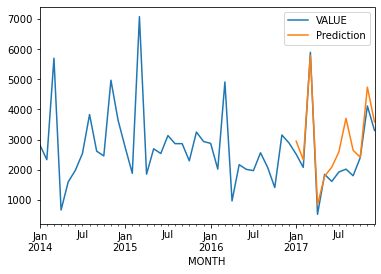

In [73]:
#Conactenating the observed and forecast model and plotting the graph
pd.concat([ABC_df_Pesticides_AA['VALUE'],forecast_df],axis=1).plot()

In [74]:
forecast1 = model.predict(n_periods=predict_periods,return_conf_int=True)
forecast1

(array([2947.62079614, 2331.42666023, 5790.94393118,  836.0028139 ,
        1786.47218496, 2082.73162493, 2590.95626667, 3705.63299507,
        2644.37235554, 2411.69627027, 4740.01292123, 3584.47627405]),
 array([[1960.4318433 , 3934.80974899],
        [1244.37949991, 3418.47382055],
        [4670.42358933, 6911.46427303],
        [-317.01936466, 1989.02499246],
        [ 601.83956174, 2971.10480818],
        [ 867.31039764, 3298.15285222],
        [1345.50732453, 3836.40520882],
        [2430.86345698, 4980.40253316],
        [1340.94161975, 3947.80309132],
        [1080.22115194, 3743.1713886 ],
        [3381.07204743, 6098.95379503],
        [2198.61386882, 4970.33867928]]))

In [75]:
forecast_range=pd.date_range(start= pd.to_datetime(test_start_date) ,periods= predict_periods,freq='MS')
forecast_range

DatetimeIndex(['2017-01-01', '2017-02-01', '2017-03-01', '2017-04-01',
               '2017-05-01', '2017-06-01', '2017-07-01', '2017-08-01',
               '2017-09-01', '2017-10-01', '2017-11-01', '2017-12-01'],
              dtype='datetime64[ns]', freq='MS')

In [76]:
forecast1_df = pd.DataFrame(forecast1[0],index= forecast_range,columns=['Prediction'])

In [77]:
forecast1_df

Prediction
2017-01-01  2947.620796
2017-02-01  2331.426660
2017-03-01  5790.943931
2017-04-01   836.002814
2017-05-01  1786.472185
2017-06-01  2082.731625
2017-07-01  2590.956267
2017-08-01  3705.632995
2017-09-01  2644.372356
2017-10-01  2411.696270
2017-11-01  4740.012921
2017-12-01  3584.476274

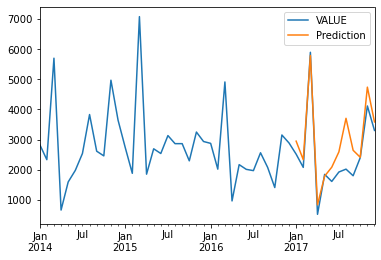

In [78]:
pd.concat([ABC_df_Pesticides_AA['VALUE'],forecast1_df],axis=1).plot()

In [79]:
lower = pd.Series(forecast1[1][:,0],index=forecast_range)
upper = pd.Series(forecast1[1][:,1],index=forecast_range)

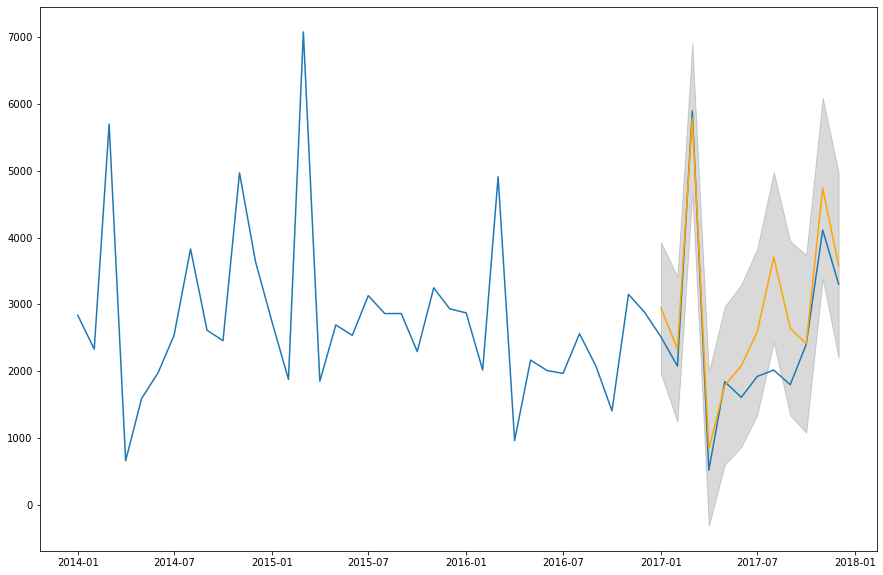

In [80]:
plt.figure(figsize=(15,10))
plt.plot(ABC_df_Pesticides_AA['VALUE'])
plt.plot(forecast1_df,color = 'orange')
plt.fill_between(forecast_range,lower,upper,color = 'k',alpha = .15)


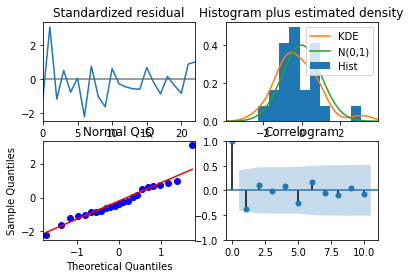

In [81]:
out = model.plot_diagnostics()

In [82]:
residuals_AA = test['VALUE'] - forecast_df['Prediction']
residuals_AA

MONTH
2017-01-01    -431.710865
2017-02-01    -254.426660
2017-03-01     106.056069
2017-04-01    -316.872970
2017-05-01      58.226636
2017-06-01    -472.434525
2017-07-01    -667.740338
2017-08-01   -1687.163620
2017-09-01    -845.122056
2017-10-01     -10.710020
2017-11-01    -624.466371
2017-12-01    -281.121224
dtype: float64

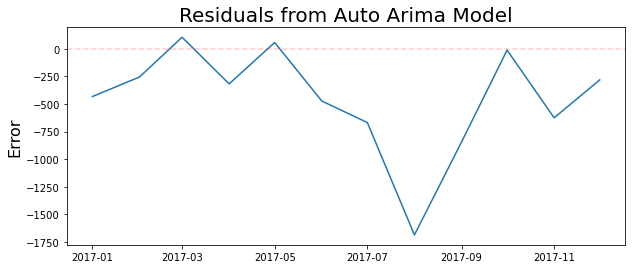

In [83]:
plt.figure(figsize=(10,4))
plt.plot(residuals_AA)
plt.title('Residuals from Auto Arima Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0, color='r', linestyle='--', alpha=0.2)

Text(0, 0.5, 'Sales')

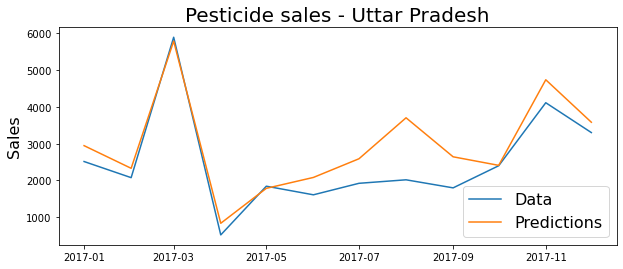

In [84]:
plt.figure(figsize=(10,4))

plt.plot(test)
plt.plot(forecast_df)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Pesticide sales - Uttar Pradesh', fontsize=20)
plt.ylabel('Sales', fontsize=16)

In [85]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals_AA**2)))

Root Mean Squared Error: 649.6845331024516


In [86]:
print(mean_absolute_error(test['VALUE'] ,forecast_df['Prediction']))

479.6709461676701


In [87]:
#Calculate MAPE%
y_true = test.loc[pd.to_datetime(test_start_date):].values
y_pred = forecast_df.loc[pd.to_datetime(test_start_date):].values

p_mean_absolute_percentage_error(y_true, y_pred)

26.179009296403272

# ARMA model

In [88]:
ABC_df_Pesticides_ARMA = ABC_df_Pesticides.copy(deep=True)

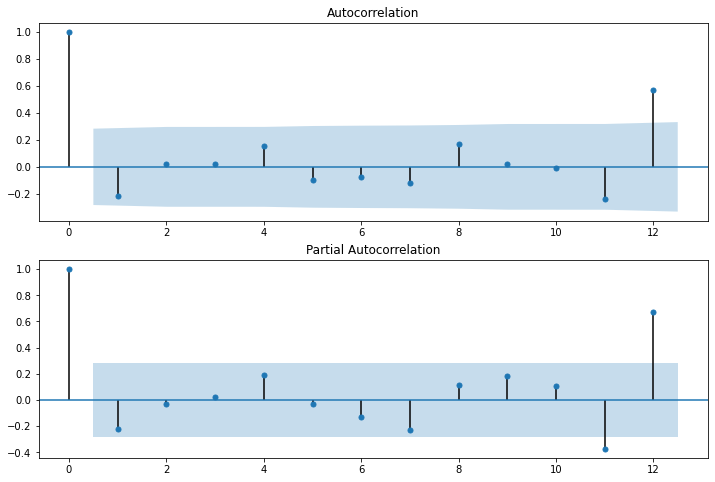

In [89]:
fig = plt.figure(figsize=(12,8))
ax1=fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ABC_df_Pesticides_ARMA,lags=predict_periods,ax = ax1)
ax2=fig.add_subplot(212)
fig= sm.graphics.tsa.plot_pacf(ABC_df_Pesticides_ARMA,lags=predict_periods,ax = ax2)

In [90]:
train = ABC_df_Pesticides_ARMA[(ABC_df_Pesticides_ARMA.index.get_level_values(0) >= pd.to_datetime(train_start_date)) &
                               (ABC_df_Pesticides_ARMA.index.get_level_values(0) <= pd.to_datetime(train_end_date))]
test = ABC_df_Pesticides_ARMA[(ABC_df_Pesticides_ARMA.index.get_level_values(0) > pd.to_datetime(train_end_date))]

In [91]:
train

VALUE
MONTH                  
2014-01-01  2838.262500
2014-02-01  2332.428275
2014-03-01  5700.845625
2014-04-01   660.625000
2014-05-01  1593.079476
2014-06-01  1978.078821
2014-07-01  2538.479155
2014-08-01  3830.933906
2014-09-01  2614.252500
2014-10-01  2458.408125
2014-11-01  4970.405625
2014-12-01  3644.532187
2015-01-01  2742.117656
2015-02-01  1879.643438
2015-03-01  7080.092344
2015-04-01  1851.711618
2015-05-01  2693.603352
2015-06-01  2537.732935
2015-07-01  3132.405925
2015-08-01  2864.210625
2015-09-01  2864.695781
2015-10-01  2294.491875
2015-11-01  3249.614063
2015-12-01  2935.531406
2016-01-01  2874.163125
2016-02-01  2018.479219
2016-03-01  4912.333969
2016-04-01   963.712742
2016-05-01  2167.770170
2016-06-01  2011.367045
2016-07-01  1969.149375
2016-08-01  2561.995312
2016-09-01  2075.745000
2016-10-01  1407.628594
2016-11-01  3151.923750
2016-12-01  2886.590250

In [92]:
# define model
model = ARMA(train, order=(1,1))

In [93]:
model_fit = model.fit()

In [94]:
#summary of the model
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                  VALUE   No. Observations:                   36
Model:                     ARMA(1, 1)   Log Likelihood                -306.465
Method:                       css-mle   S.D. of innovations           1203.657
Date:                Thu, 24 Jun 2021   AIC                            620.930
Time:                        15:50:53   BIC                            627.264
Sample:                    01-01-2014   HQIC                           623.141
                         - 12-01-2016                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        2784.6994    156.342     17.812      0.000    2478.274    3091.125
ar.L1.VALUE    -0.0989      0.484     -0.204      0.838      -1.048       0.851
ma.L1.VALUE    -0.1500      0.468     -0.320    

In [95]:
test

VALUE
MONTH                  
2017-01-01  2515.909932
2017-02-01  2077.000000
2017-03-01  5897.000000
2017-04-01   519.129844
2017-05-01  1844.698821
2017-06-01  1610.297100
2017-07-01  1923.215929
2017-08-01  2018.469375
2017-09-01  1799.250300
2017-10-01  2400.986250
2017-11-01  4115.546550
2017-12-01  3303.355050

In [96]:
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12 entries, 2017-01-01 to 2017-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   VALUE   12 non-null     float64
dtypes: float64(1)
memory usage: 192.0 bytes


In [97]:
#get the predictions and residuals
predictions = model_fit.predict(start=pd.to_datetime(test_start_date), end = pd.to_datetime(test_end_date))

In [98]:
predictions

2017-01-01    2753.987083
2017-02-01    2787.735442
2017-03-01    2784.399311
2017-04-01    2784.729098
2017-05-01    2784.696498
2017-06-01    2784.699720
2017-07-01    2784.699402
2017-08-01    2784.699433
2017-09-01    2784.699430
2017-10-01    2784.699431
2017-11-01    2784.699430
2017-12-01    2784.699430
Freq: MS, dtype: float64

In [99]:
Pred_range=pd.date_range(start = pd.to_datetime(test_end_date),periods= predict_periods,freq='MS')
Pred_range

DatetimeIndex(['2017-12-01', '2018-01-01', '2018-02-01', '2018-03-01',
               '2018-04-01', '2018-05-01', '2018-06-01', '2018-07-01',
               '2018-08-01', '2018-09-01', '2018-10-01', '2018-11-01'],
              dtype='datetime64[ns]', freq='MS')

In [100]:
Pred_df = predictions.to_frame()
Pred_df.info()
Pred_df

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12 entries, 2017-01-01 to 2017-12-01
Freq: MS
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       12 non-null     float64
dtypes: float64(1)
memory usage: 192.0 bytes


0
2017-01-01  2753.987083
2017-02-01  2787.735442
2017-03-01  2784.399311
2017-04-01  2784.729098
2017-05-01  2784.696498
2017-06-01  2784.699720
2017-07-01  2784.699402
2017-08-01  2784.699433
2017-09-01  2784.699430
2017-10-01  2784.699431
2017-11-01  2784.699430
2017-12-01  2784.699430

In [101]:
Pred_df.columns = ['PRED_VALUE']

In [102]:
residuals_ARMA = test['VALUE'] - Pred_df['PRED_VALUE']
residuals_ARMA

MONTH
2017-01-01    -238.077152
2017-02-01    -710.735442
2017-03-01    3112.600689
2017-04-01   -2265.599254
2017-05-01    -939.997676
2017-06-01   -1174.402620
2017-07-01    -861.483473
2017-08-01    -766.230058
2017-09-01    -985.449130
2017-10-01    -383.713181
2017-11-01    1330.847120
2017-12-01     518.655620
dtype: float64

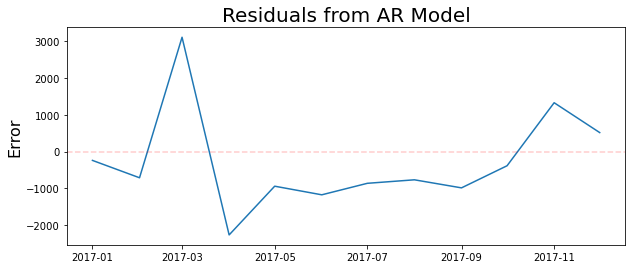

In [103]:
plt.figure(figsize=(10,4))
plt.plot(residuals_ARMA)
plt.title('Residuals from AR Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0, color='r', linestyle='--', alpha=0.2)

Text(0, 0.5, 'Sales')

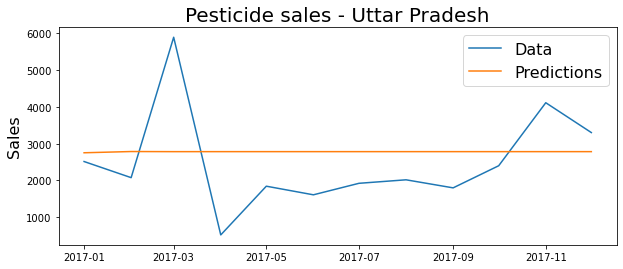

In [104]:
plt.figure(figsize=(10,4))

plt.plot(test)
plt.plot(Pred_df)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Pesticide sales - Uttar Pradesh', fontsize=20)
plt.ylabel('Sales', fontsize=16)

In [105]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals_ARMA**2)))

Root Mean Squared Error: 1358.1124018122357


In [106]:
print(mean_absolute_error(test['VALUE'] ,Pred_df['PRED_VALUE']))

1107.3159512258837


In [107]:
#Calculate MAPE%
y_true = test.loc[pd.to_datetime(test_start_date):].values
y_pred = Pred_df.loc[pd.to_datetime(test_start_date):].values

p_mean_absolute_percentage_error(y_true, y_pred)

71.52660026893972

# SARIMAX Model

In [108]:
ABC_df_Pesticides_SARIMAX = ABC_df_Pesticides.copy(deep=True)

In [109]:
p = range(0, 3)
d = range(0, 1)
q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[0], x[0], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(ABC_df_Pesticides_SARIMAX,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
               
            continue            

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 0, 12)
SARIMAX: (0, 0, 1) x (0, 0, 0, 12)
SARIMAX: (0, 0, 2) x (1, 1, 1, 12)
SARIMAX: (0, 0, 2) x (1, 1, 1, 12)
ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:888.0042165264042
ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:888.0042165264042
ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:888.0042165264042
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:357.10509906166817
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:357.10509906166817
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:357.10509906166817
ARIMA(0, 0, 0)x(2, 2, 2, 12)12 - AIC:10.0
ARIMA(0, 0, 0)x(2, 2, 2, 12)12 - AIC:10.0
ARIMA(0, 0, 0)x(2, 2, 2, 12)12 - AIC:10.0
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:852.3438948392843
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:852.3438948392843
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:852.3438948392843
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:335.0046826071596
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:335.0046826071596
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:335.0046826071596
ARIMA(0, 0, 1)

In [110]:
# Fitting the data to SARIMA model 
model = sm.tsa.statespace.SARIMAX(ABC_df_Pesticides_SARIMAX['VALUE'], 
                                order=(0, 0, 0),
                                seasonal_order=(2, 2, 2, 12),  
                                continueenforce_invertibility=False)

In [111]:
results = model.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.2408      2.998      0.080      0.936      -5.635       6.116
ar.S.L24      -0.7413      7.394     -0.100      0.920     -15.233      13.750
ma.S.L12      -1.5163     12.194     -0.124      0.901     -25.416      22.384
ma.S.L24       0.9067     36.799      0.025      0.980     -71.219      73.032
sigma2      3.683e+05    5.5e-05   6.69e+09      0.000    3.68e+05    3.68e+05


In [112]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   SARIMAX Results                                   
=====================================================================================
Dep. Variable:                         VALUE   No. Observations:                   48
Model:             SARIMAX(2, 2, [1, 2], 12)   Log Likelihood                -199.407
Date:                       Thu, 24 Jun 2021   AIC                            408.814
Time:                               15:51:19   BIC                            414.704
Sample:                           01-01-2014   HQIC                           410.376
                                - 12-01-2017                                         
Covariance Type:                         opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.2408      2.998      0.080      0.936      -5.635       6.116
ar.S.L24      -0.7413      7.394     -0.100      0.920     -15.233      13.750
ma.S.L12      -1.5163     12.194     -0.124      0.901     -25.416      22.384
ma.S.L24       0.9067     36.799      0.025      0.980     -71.219      73.032
sigma2      3.683e+05    5.5e-05   6.69e+09      0.000    3.68e+05    3.68e+05
===================================================================================
Ljung-Box (Q):                       29.24   Jarque-Bera (JB):                 0.14
Prob(Q):                              0.17   Prob(JB):                         0.93
Heteroskedasticity (H):               0.36   Skew:                            -0.11
Prob(H) (two-sided):                  0.17   Kurtosis:                         2.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.13e+27. Standard errors may be unstable.
"""

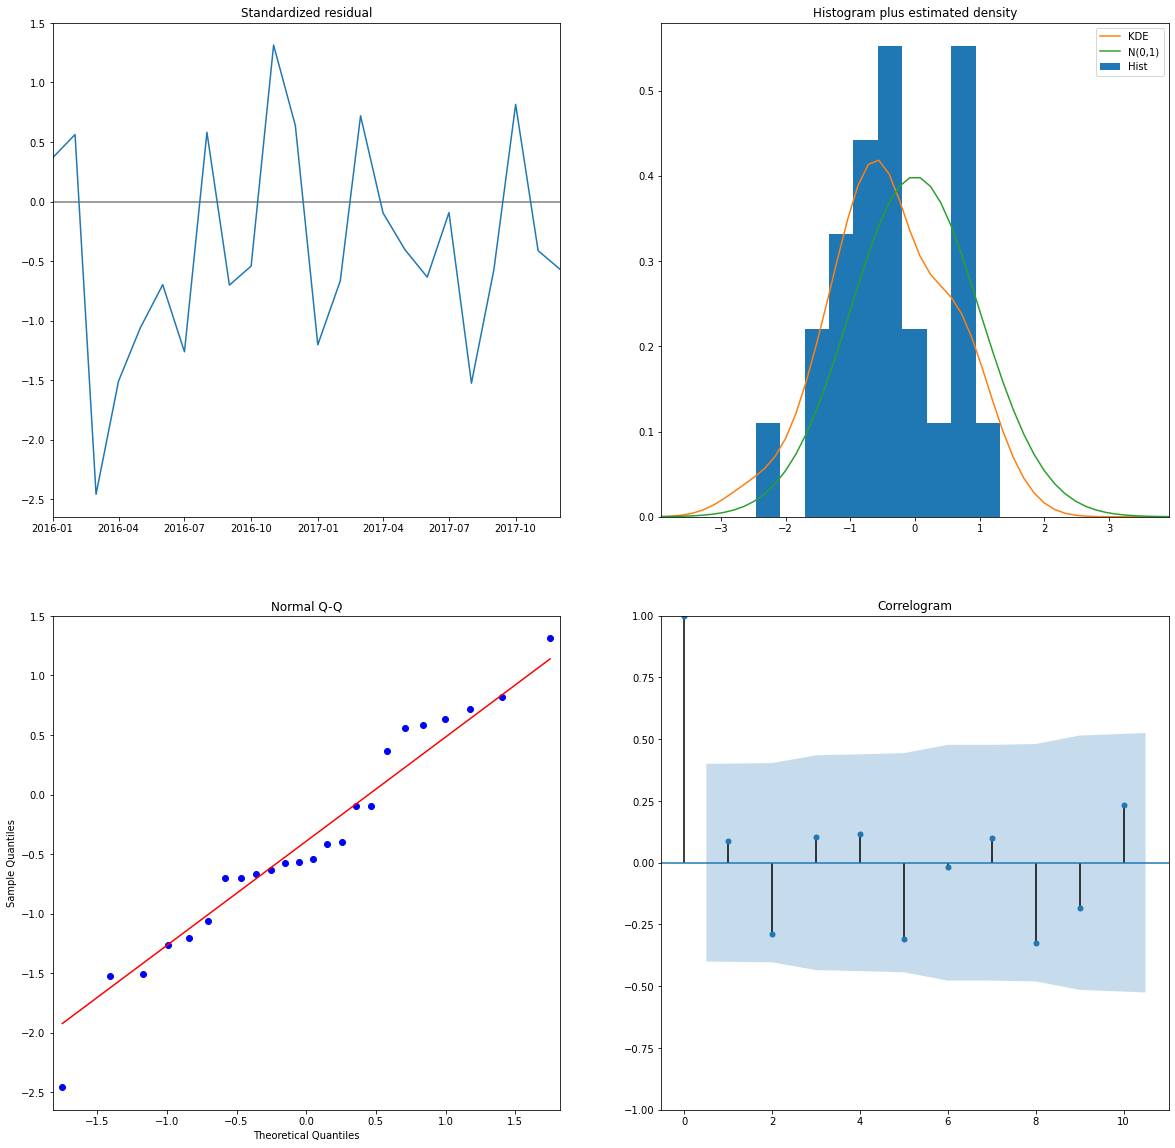

In [113]:
# Checking diagnostic plots
results.plot_diagnostics(figsize=(20, 20))
plt.show()

In [114]:
train = ABC_df_Pesticides_SARIMAX[(ABC_df_Pesticides_SARIMAX.index.get_level_values(0) >= pd.to_datetime(train_start_date)) &
                               (ABC_df_Pesticides_SARIMAX.index.get_level_values(0) <= pd.to_datetime(train_end_date))]
test = ABC_df_Pesticides_SARIMAX[(ABC_df_Pesticides_SARIMAX.index.get_level_values(0) > pd.to_datetime(train_end_date))]

In [115]:
forecast = results.predict(12)
forecast

2015-01-01    4655.634817
2015-02-01    3825.909085
2015-03-01    9351.163037
2015-04-01    1083.630831
2015-05-01    2613.146696
2015-06-01    3244.665577
2015-07-01    4163.896728
2015-08-01    6283.925210
2015-09-01    4288.188623
2015-10-01    4032.555291
2015-11-01    8153.013854
2015-12-01    5978.168314
2016-01-01    2471.087086
2016-02-01    1399.620735
2016-03-01    7618.073103
2016-04-01    2623.939280
2016-05-01    3336.191885
2016-06-01    2780.216638
2016-07-01    3358.035798
2016-08-01    1922.256103
2016-09-01    2848.413382
2016-10-01    2004.224990
2016-11-01    1706.342491
2016-12-01    2184.438377
2017-01-01    3659.727986
2017-02-01    2710.673615
2017-03-01    5212.610039
2017-04-01     610.387956
2017-05-01    2227.174742
2017-06-01    2214.444840
2017-07-01    2011.735982
2017-08-01    3469.513547
2017-09-01    2342.787578
2017-10-01    1625.395100
2017-11-01    4507.927952
2017-12-01    3843.590626
Freq: MS, dtype: float64

In [116]:
Predicted_df = pd.DataFrame(forecast.loc[forecast.index.isin(test.index)], columns=["PRED_VALUE"])
Predicted_df

PRED_VALUE
2017-01-01  3659.727986
2017-02-01  2710.673615
2017-03-01  5212.610039
2017-04-01   610.387956
2017-05-01  2227.174742
2017-06-01  2214.444840
2017-07-01  2011.735982
2017-08-01  3469.513547
2017-09-01  2342.787578
2017-10-01  1625.395100
2017-11-01  4507.927952
2017-12-01  3843.590626

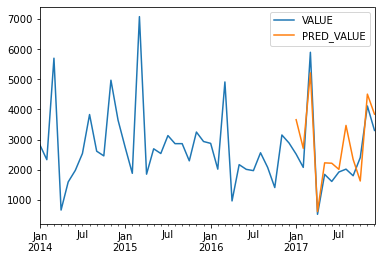

In [117]:
pd.concat([ABC_df_Pesticides_SARIMAX['VALUE'], Predicted_df], axis=1).plot()

In [118]:
residuals_SARIMAX = test['VALUE'] - Pred_df['PRED_VALUE']
residuals_SARIMAX

MONTH
2017-01-01    -238.077152
2017-02-01    -710.735442
2017-03-01    3112.600689
2017-04-01   -2265.599254
2017-05-01    -939.997676
2017-06-01   -1174.402620
2017-07-01    -861.483473
2017-08-01    -766.230058
2017-09-01    -985.449130
2017-10-01    -383.713181
2017-11-01    1330.847120
2017-12-01     518.655620
dtype: float64

In [119]:
#get the predictions

predict_future = results.forecast(len(test))
predict_future

2018-01-01    3003.193820
2018-02-01    2414.287438
2018-03-01    8912.391217
2018-04-01    1345.994747
2018-05-01    2795.299295
2018-06-01    2371.904573
2018-07-01    3144.783255
2018-08-01    2396.656305
2018-09-01    2688.902836
2018-10-01    3525.713695
2018-11-01    4880.771739
2018-12-01    4019.156463
Freq: MS, dtype: float64

In [120]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals_SARIMAX**2)))

Root Mean Squared Error: 1358.1124018122357


In [121]:
print(mean_absolute_error(test['VALUE'] ,Pred_df['PRED_VALUE']))

1107.3159512258837


In [122]:
#Calculate MAPE%
y_true = test.loc[pd.to_datetime(test_start_date):].values
y_pred = Pred_df.loc[pd.to_datetime(test_start_date):].values

p_mean_absolute_percentage_error(y_true, y_pred)

71.52660026893972

# Holt-Winters - ETS(A, A, A) - Holt Winter's linear method with additive errors

In [123]:
ABC_df_Pesticides_hwm =  ABC_df_Pesticides.copy(deep=True)

In [124]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [125]:
#Splitting the data into training and testing set
train = ABC_df_Pesticides_hwm[(ABC_df_Pesticides_hwm.index.get_level_values(0)>= pd.to_datetime(train_start_date) ) &
                               (ABC_df_Pesticides_hwm.index.get_level_values(0)<= pd.to_datetime(train_end_date))]
test = ABC_df_Pesticides_hwm[(ABC_df_Pesticides_hwm.index.get_level_values(0)> pd.to_datetime(train_end_date))]

In [126]:
pred1 = ExponentialSmoothing(np.asarray(train['VALUE']), trend='additive', damped=False, seasonal='additive',
                                  seasonal_periods = 12).fit() #[:'2017-01-01']
print('')
print('== Holt-Winters Additive ETS(A,A,A) Parameters ==')
print('')
alpha_value = np.round(pred1.params['smoothing_level'], 4)
print('Smoothing Level: ', alpha_value)
print('Smoothing Slope: ', np.round(pred1.params['smoothing_slope'], 4))
print('Smoothing Seasonal: ', np.round(pred1.params['smoothing_seasonal'], 4))
print('Initial Level: ', np.round(pred1.params['initial_level'], 4))
print('Initial Slope: ', np.round(pred1.params['initial_slope'], 4))
print('Initial Seasons: ', np.round(pred1.params['initial_seasons'], 4))
print('')

### Forecast for next 12 months

y_pred1 =  pred1.forecast(steps = 12)
df_pred1 = pd.DataFrame({'Y_hat':y_pred1,'Y':test['VALUE']})
print(df_pred1)


== Holt-Winters Additive ETS(A,A,A) Parameters ==

Smoothing Level:  0.3382
Smoothing Slope:  0.0
Smoothing Seasonal:  0.0
Initial Level:  2621.0602
Initial Slope:  0.0
Initial Seasons:  [   96.0334  -637.143   3142.1017 -1576.7799  -565.2063  -530.8076
  -155.228    389.3553  -150.7116  -585.3437  1161.9439   557.4533]

                  Y_hat            Y
MONTH                               
2017-01-01  2287.187110  2515.909932
2017-02-01  1554.010685  2077.000000
2017-03-01  5333.255344  5897.000000
2017-04-01   614.373776   519.129844
2017-05-01  1625.947397  1844.698821
2017-06-01  1660.346114  1610.297100
2017-07-01  2035.925701  1923.215929
2017-08-01  2580.508943  2018.469375
2017-09-01  2040.442083  1799.250300
2017-10-01  1605.809920  2400.986250
2017-11-01  3353.097555  4115.546550
2017-12-01  2748.606984  3303.355050


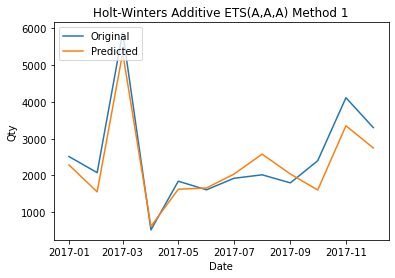

In [127]:
### Plot

fig2, ax = plt.subplots()
ax.plot(df_pred1.Y, label='Original')
ax.plot(df_pred1.Y_hat, label='Predicted')

plt.legend(loc='upper left')
plt.title('Holt-Winters Additive ETS(A,A,A) Method 1')
plt.ylabel('Qty')
plt.xlabel('Date')
plt.show()

In [128]:
residuals_hwm = df_pred1.Y - df_pred1.Y_hat
residuals_hwm


MONTH
2017-01-01    228.722822
2017-02-01    522.989315
2017-03-01    563.744656
2017-04-01    -95.243932
2017-05-01    218.751425
2017-06-01    -50.049014
2017-07-01   -112.709772
2017-08-01   -562.039568
2017-09-01   -241.191783
2017-10-01    795.176330
2017-11-01    762.448995
2017-12-01    554.748066
dtype: float64

In [129]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals_hwm**2)))

Root Mean Squared Error: 466.47733197684727


In [130]:
print(mean_absolute_error(df_pred1.Y, df_pred1.Y_hat))

392.3179732403833


In [131]:

mape    =  p_mean_absolute_percentage_error(df_pred1.Y, df_pred1.Y_hat)

print("For alpha = %1.2f,  MAPE is %3.2f" %(alpha_value, mape))

For alpha = 0.34,  MAPE is 16.06


In [132]:
#Future forecast
final_model = ExponentialSmoothing(ABC_df_Pesticides_hwm['VALUE'], trend='additive', damped=False, seasonal='additive',
                                  seasonal_periods = 12).fit()

In [133]:
pred=final_model.forecast(12)
pred

2018-01-01    2732.229769
2018-02-01    2060.595034
2018-03-01    5884.726851
2018-04-01     987.363584
2018-05-01    2064.224103
2018-06-01    2028.607786
2018-07-01    2381.884776
2018-08-01    2811.785941
2018-09-01    2328.593355
2018-10-01    2127.581498
2018-11-01    3867.715914
2018-12-01    3188.526442
Freq: MS, dtype: float64

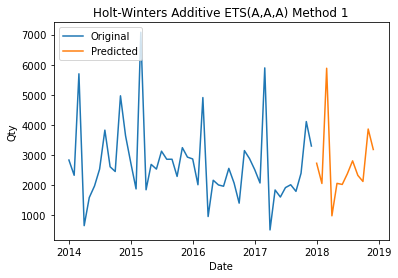

In [134]:
### Plot

fig2, ax = plt.subplots()
ax.plot(ABC_df_Pesticides_hwm['VALUE'], label='Original')
ax.plot(pred, label='Predicted')

plt.legend(loc='upper left')
plt.title('Holt-Winters Additive ETS(A,A,A) Method 1')
plt.ylabel('Qty')
plt.xlabel('Date')
plt.show()

# To check if Rainfall has any effect on Insecticides sales

In [135]:
Rainfall = [12.9,16.7,26.5,7.5, 20,25.8,71,33.5,67,10.8,0.2,9.4,12.1,6.6,70.7,34.9,8.3,43.5,127.9,84.4,32,3.8,2.3,0.2,
            0,1.1,20.7,0.6,26.8,34.8,155.1,133.8,13.7,5.2,0,0.9,33.8,0.3,7.2,3.7,10.1,121.8,67.7,74.7,91.8,0,1.8,4.2]

In [136]:
ABC_df_Pesticides['Rainfall'] = Rainfall[rolling_period - 3:]

Text(0, 0.5, 'Sales')

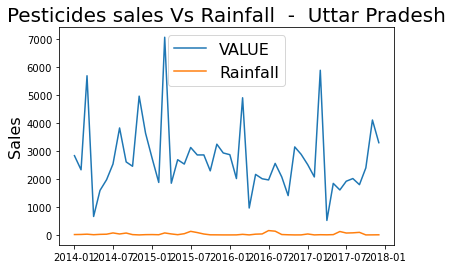

In [137]:
plt.plot(ABC_df_Pesticides)

plt.legend(('VALUE', 'Rainfall'), fontsize=16)

plt.title('Pesticides sales Vs Rainfall  -  Uttar Pradesh', fontsize=20)
plt.ylabel('Sales', fontsize=16)

#Feature scaling for 'VALUE' column as Rainfall column

In [138]:
#Taking Rainfall and Value column on a common scale
ABC_df_Pesticides['VALUE'] = ABC_df_Pesticides['VALUE']/10000

In [139]:
mpl.rcParams['figure.figsize'] = (10, 8)
mpl.rcParams['axes.grid'] = False

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002A668BAF310>,
      dtype=object)

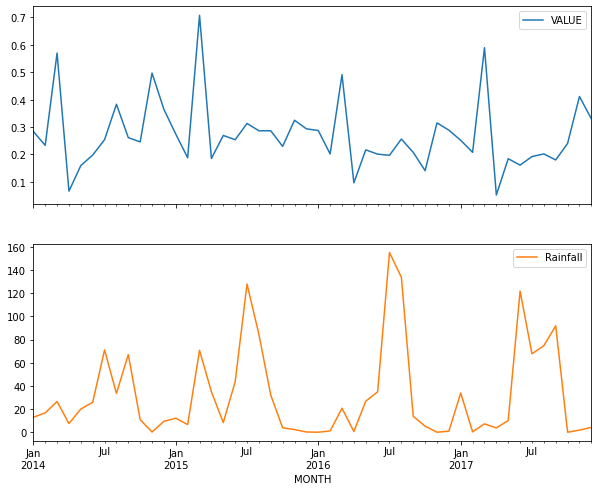

In [140]:
ABC_df_Pesticides.plot(subplots=True)

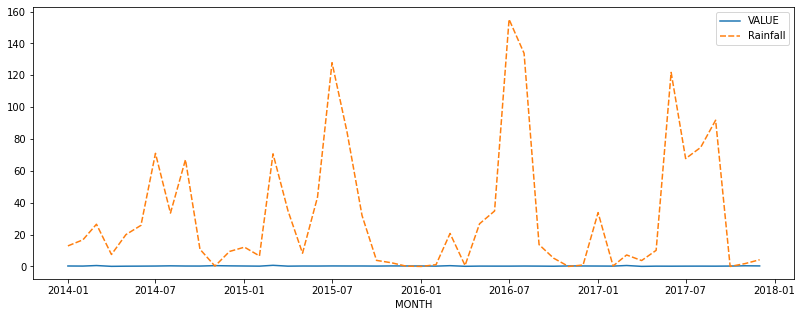

In [141]:
plt.figure(figsize = (30,5))
plt.subplot(1,2,1)
sns.lineplot(data=ABC_df_Pesticides)

In [142]:
#to find the coorelation betwween Rainfall and Value

In [143]:
col1 = ABC_df_Pesticides["Rainfall"]
col2 = ABC_df_Pesticides["VALUE"]

In [144]:
correlation = col1.corr(col2)
correlation

-0.036711164422418244

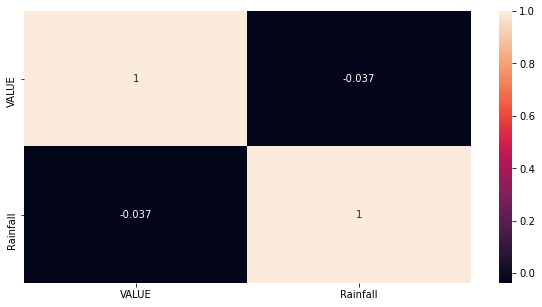

In [145]:
plt.figure(figsize = (10,5))
sns.heatmap(ABC_df_Pesticides.corr(),annot = True)